In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import re
import string
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

tqdm_notebook.pandas()

sns.set_style('darkgrid')

nlp = spacy.load('en_core_web_sm')

In [2]:
df = pd.read_csv('../data/final_data.csv')

In [3]:
df.isna().sum() / len(df) * 100

short_descriptions    1.620004
assignment_groups     1.614584
dtype: float64

In [4]:
df.shape

(166049, 2)

In [5]:
non_dupl = df[~df.duplicated()].copy()
non_dupl.shape

(116739, 2)

In [6]:
non_dupl.isna().sum() / len(non_dupl) * 100

short_descriptions    0.004283
assignment_groups     0.009423
dtype: float64

In [7]:
non_dupl.dropna(inplace=True)

In [8]:
non_dupl.tail()

,short_descriptions,assignment_groups
166044,Data files per our call,PZC-FJ-ServiceDesk
166045,Approver Matrix,PZC-FJ-ServiceDesk
166046,a new Product Hierarchy Level 5 and 6: Vegeta...,PZC-FJ-ServiceDesk
166047,[SAP] Create SAP account in PROD for Charala...,PZC-FJ-ServiceDesk
166048,APO Daily and Monthly Chains to be triggere...,PZC-FJ-ServiceDesk


In [9]:
non_dupl['short_descriptions'] = non_dupl['short_descriptions'][
    non_dupl['short_descriptions'].apply(lambda x: len(x.split()) > 2) == True]

In [10]:
non_dupl.isna().sum() / len(non_dupl) * 100

short_descriptions    4.574038
assignment_groups     0.000000
dtype: float64

In [11]:
non_dupl.dropna(inplace=True)

In [12]:
non_dupl.tail()

,short_descriptions,assignment_groups
166043,SAP ECP- Access Issue,PZC-FJ-ServiceDesk
166044,Data files per our call,PZC-FJ-ServiceDesk
166046,a new Product Hierarchy Level 5 and 6: Vegeta...,PZC-FJ-ServiceDesk
166047,[SAP] Create SAP account in PROD for Charala...,PZC-FJ-ServiceDesk
166048,APO Daily and Monthly Chains to be triggere...,PZC-FJ-ServiceDesk


In [13]:
non_dupl.shape

(111385, 2)

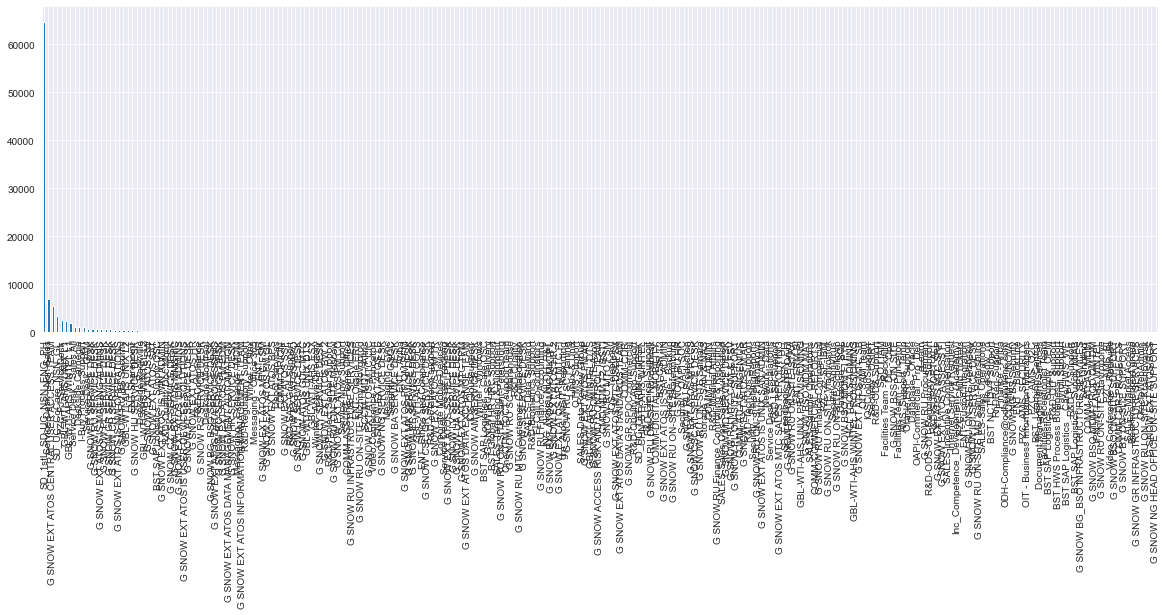

In [14]:
cnt_asgn_grps = non_dupl['assignment_groups'].value_counts()

cnt_asgn_grps.plot(kind='bar', figsize=(20, 6))
plt.show()

In [15]:
cnt_asgn_grps.min(), cnt_asgn_grps.max()

(1, 64695)

In [16]:
counts = sorted(cnt_asgn_grps, reverse=True)

In [17]:
len(counts)

253

In [18]:
len([f for f in counts if f > 250])

39

In [19]:
cnt_asgn_grps.head()

SD_1stL_SD-UC_NSN_ENG_PH                    64695
Service Desk - Non Sales                     6986
G SNOW EXT ATOS CENTRAL USER ACCESS TEAM     5419
SD_UC_CoCare_NSN_GL                          3349
PZC-FJ-ServiceDesk                           2534
Name: assignment_groups, dtype: int64

In [20]:
39 * 7000

273000

In [21]:
max_class = non_dupl[non_dupl['assignment_groups'] == 'SD_1stL_SD-UC_NSN_ENG_PH']

In [22]:
max_class = max_class.sample(7000)

In [23]:
test_df = non_dupl[~non_dupl['assignment_groups'].isin(['SD_1stL_SD-UC_NSN_ENG_PH'])]

In [24]:
cnts = test_df['assignment_groups'].value_counts()

In [25]:
valid_labels = cnts[cnts > 250]

In [26]:
test_df = non_dupl[non_dupl['assignment_groups'].isin(valid_labels.index.to_list())]

In [27]:
test_df.shape

(38377, 2)

In [28]:
new_df = test_df.append(max_class)
new_df = new_df.sample(frac=1)

In [29]:
new_df.shape

(45377, 2)

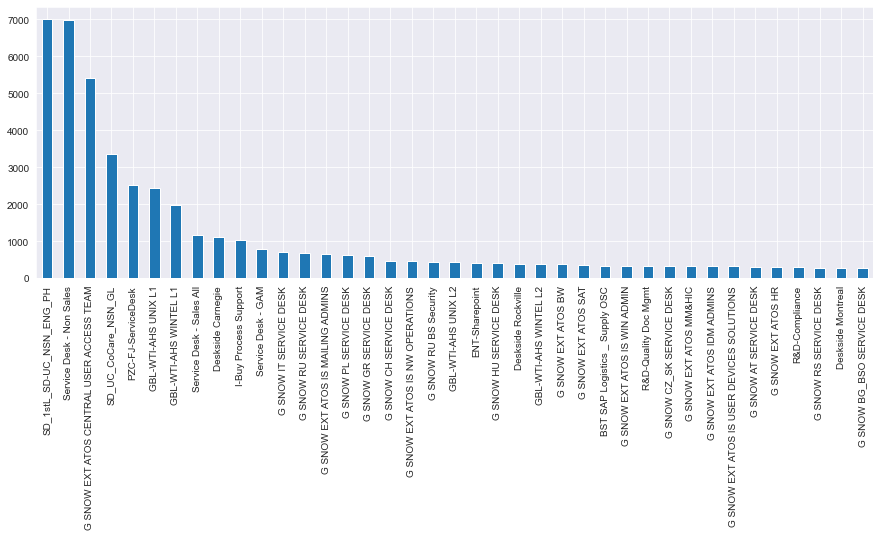

In [30]:
new_df['assignment_groups'].value_counts().plot(kind='bar', figsize=(15, 5))
plt.show()

In [31]:
def clean_text(text: str):
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    return text


def preprocess_text(text: str):
    sentence = list()
    doc = nlp(text)
    for word in doc:
        sentence.append(word.lemma_)
    return ' '.join(sentence)

In [32]:
new_df['short_descriptions'] = new_df['short_descriptions'].progress_apply(lambda x:clean_text(x))

In [33]:
new_df['short_descriptions'] = new_df['short_descriptions'].progress_apply(lambda x:preprocess_text(x))

df.tail()

,short_descriptions,assignment_groups
166044,Data files per our call,PZC-FJ-ServiceDesk
166045,Approver Matrix,PZC-FJ-ServiceDesk
166046,a new Product Hierarchy Level 5 and 6: Vegeta...,PZC-FJ-ServiceDesk
166047,[SAP] Create SAP account in PROD for Charala...,PZC-FJ-ServiceDesk
166048,APO Daily and Monthly Chains to be triggere...,PZC-FJ-ServiceDesk


In [35]:
new_df['short_descriptions'] = new_df['short_descriptions'].str.replace('-PRON-', '')
df.tail()

,short_descriptions,assignment_groups
166044,Data files per our call,PZC-FJ-ServiceDesk
166045,Approver Matrix,PZC-FJ-ServiceDesk
166046,a new Product Hierarchy Level 5 and 6: Vegeta...,PZC-FJ-ServiceDesk
166047,[SAP] Create SAP account in PROD for Charala...,PZC-FJ-ServiceDesk
166048,APO Daily and Monthly Chains to be triggere...,PZC-FJ-ServiceDesk


In [37]:
new_df = new_df.sample(frac=1)
new_df.shape

(45377, 2)

In [38]:
X, y = new_df['short_descriptions'], new_df['assignment_groups']

In [39]:
X.size, y.size

(45377, 45377)

In [40]:
counts = sorted(Counter(y).values(), reverse=True)

In [41]:
len(Counter(y)) * counts[0]

273000

In [42]:
from imblearn.over_sampling import SMOTE

In [43]:
over_sampler = SMOTE()

In [44]:
vectorizer = CountVectorizer()
encoder = LabelEncoder()

In [45]:
X_vec = vectorizer.fit_transform(X)
y_enc = encoder.fit_transform(y)

In [46]:
%%time

X, y = over_sampler.fit_resample(X_vec, y_enc)

Wall time: 4.06 s


In [47]:
%%time

X = vectorizer.inverse_transform(X)
y = encoder.inverse_transform(y)

Wall time: 47.7 s


In [48]:
len(X), len(y)

(273000, 273000)

In [49]:
res_df = pd.DataFrame(
    {
        'short_descriptions': X,
        'assignment_groups': y
    }
)

In [50]:
res_df.shape

(273000, 2)

In [51]:
res_df.tail()

,short_descriptions,assignment_groups
272995,"[not, orion]",Service Desk - Sales All
272996,[],Service Desk - Sales All
272997,"[pac, to, tool, unable]",Service Desk - Sales All
272998,"[hcp, wrong]",Service Desk - Sales All
272999,"[able, not, successfully, to, user]",Service Desk - Sales All


In [52]:
def extract_from_array(text):
    return ' '.join([t for t in text])

In [53]:
res_df['short_descriptions'] = res_df['short_descriptions'].apply(lambda x:extract_from_array(x))

In [54]:
res_df.tail()

,short_descriptions,assignment_groups
272995,not orion,Service Desk - Sales All
272996,,Service Desk - Sales All
272997,pac to tool unable,Service Desk - Sales All
272998,hcp wrong,Service Desk - Sales All
272999,able not successfully to user,Service Desk - Sales All


<AxesSubplot:>

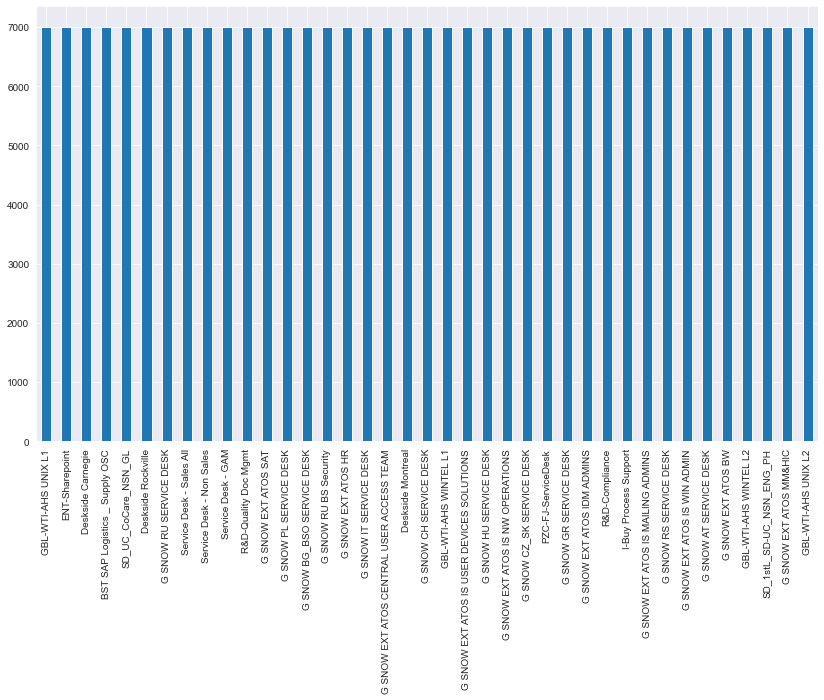

In [55]:
res_df['assignment_groups'].value_counts().plot(kind='bar', figsize=(14, 8))

In [56]:
res_df.to_csv('../data/new_balanced_data_250_preprocessed.csv', index=False)

In [57]:
joblib.dump(vectorizer, '../models/vectorizer', compress=2)

['../models/vectorizer']

In [58]:
joblib.dump(encoder, '../models/encoder', compress=2)

['../models/encoder']